In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1: Evaluate Dataset for Imbalance

Class Distribution in SDNET2018 Dataset:
           Count  Percentage
Cracked     8484   15.125152
Uncracked  47608   84.874848


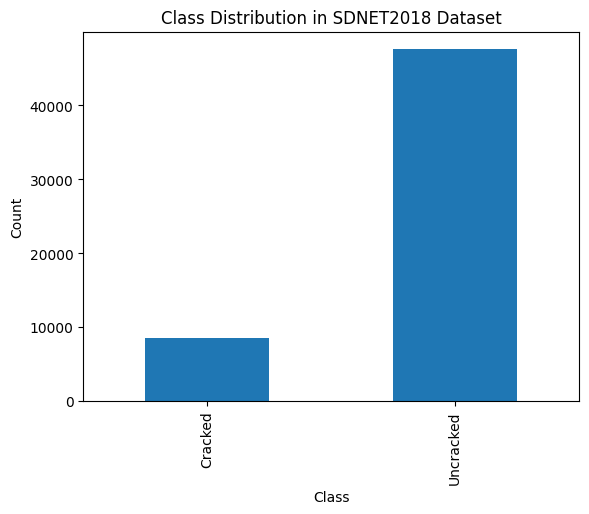

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Define dataset path
sdnet_path= '/content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL'



# Folder structure
all_subfolders = {
    'D': ['CD', 'UD'],
    'P': ['CP', 'UP'],
    'W': ['CW', 'UW']
}

# Function to evaluate dataset imbalance
def evaluate_imbalance(dataset_path):
    class_counts = {'Cracked': 0, 'Uncracked': 0}

    for category, subfolders in all_subfolders.items():
        for subfolder in subfolders:
            subfolder_path = os.path.join(dataset_path, category, subfolder)
            if os.path.exists(subfolder_path):
                num_images = len([f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.png'))])
                if subfolder in ['CD', 'CP', 'CW']:
                    class_counts['Cracked'] += num_images
                else:
                    class_counts['Uncracked'] += num_images

    df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
    df['Percentage'] = df['Count'] / df['Count'].sum() * 100

    print("Class Distribution in SDNET2018 Dataset:")
    print(df)

    df.plot(kind='bar', y='Count', legend=False)
    plt.title('Class Distribution in SDNET2018 Dataset')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    return df

# Evaluate imbalance
sdnet_imbalance = evaluate_imbalance(sdnet_path)

## Step 2: Data Splitting

In [3]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter

# Define dataset and output paths

from google.colab import drive
drive.mount('/content/drive')

sdnet_path  = '/content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL'
output_path = '/content/drive/MyDrive/Deep Learning/final/split_data'

# Create the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)


# Folder structure
all_subfolders = {
    'D': ['CD', 'UD'],
    'P': ['CP', 'UP'],
    'W': ['CW', 'UW']
}

# Define transforms (64x64)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset with binary labels
def load_sdnet_dataset(dataset_path):
    class_to_idx = {'Cracked': 0, 'Uncracked': 1}
    samples = []
    labels = []

    for category, subfolders in all_subfolders.items():
        for subfolder in subfolders:
            subfolder_path = os.path.join(dataset_path, category, subfolder)
            if os.path.exists(subfolder_path):
                for img_name in os.listdir(subfolder_path):
                    if img_name.endswith(('.jpg', '.png')):
                        img_path = os.path.join(subfolder_path, img_name)
                        label = 'Cracked' if subfolder in ['CD', 'CP', 'CW'] else 'Uncracked'
                        samples.append((img_path, class_to_idx[label]))
                        labels.append(class_to_idx[label])

    dataset = datasets.ImageFolder(dataset_path, transform=transform)
    dataset.samples = samples
    dataset.classes = ['Cracked', 'Uncracked']
    dataset.class_to_idx = class_to_idx

    return dataset, labels, samples

# Check split distribution

def print_split_distribution(indices, labels, dataset, name=""):
    subset_labels = [labels[i] for i in indices]
    counts = Counter(subset_labels)
    dist = {dataset.classes[k]: v for k, v in counts.items()}
    print(f"{name} Distribution:", dist)

# Custom split with 70/15/15

def create_custom_split(dataset, labels, samples):
    # Step 1: Split into train (70%) and temp (30% for val+test)
    train_indices, temp_indices = train_test_split(
        range(len(dataset)),
        test_size=0.3,
        random_state=42,
        shuffle=True,
        stratify=labels
    )

    # Step 2: Split temp into validation (15%) and test (15%)

    temp_labels = [labels[i] for i in temp_indices]
    val_indices, test_indices = train_test_split(
        temp_indices,
        test_size=0.5,  # 50% of 30% = 15%
        random_state=42,
        shuffle=True,
        stratify=temp_labels
    )

    # Step 3: Balance training set

    train_labels = np.array([labels[i] for i in train_indices])
    train_indices = np.array(train_indices)

    # Separate cracked and uncracked

    cracked_indices = train_indices[train_labels == 0]  # Cracked (label 0)
    uncracked_indices = train_indices[train_labels == 1]  # Uncracked (label 1)

    # Target ~19,843 per class in training

    target_per_class = len(uncracked_indices) // 2  # ~19,843

    # Undersample uncracked
    uncracked_subset = np.random.choice(uncracked_indices, size=target_per_class, replace=False)

    # Oversample cracked
    cracked_oversampled = np.random.choice(cracked_indices, size=target_per_class, replace=True)

    # Combine and shuffle
    custom_train_indices = np.concatenate([cracked_oversampled, uncracked_subset])
    np.random.shuffle(custom_train_indices)

    # Step 4: Save split details to CSV
    def save_split_to_csv(indices, split_name):
        file_paths = [samples[i][0] for i in indices]
        split_labels = [dataset.classes[labels[i]] for i in indices]
        df = pd.DataFrame({'file_path': file_paths, 'label': split_labels})
        csv_path = os.path.join(output_path, f'{split_name}_split.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved {split_name} split to {csv_path}")

    save_split_to_csv(custom_train_indices, 'train')
    save_split_to_csv(val_indices, 'validation')
    save_split_to_csv(test_indices, 'test')

    return custom_train_indices, val_indices, test_indices

# Load dataset
dataset, labels, samples = load_sdnet_dataset(sdnet_path)

# Create custom split
custom_train_indices, val_indices, test_indices = create_custom_split(dataset, labels, samples)

# Print distributions
print("\nCustom Split (70/15/15):")
print_split_distribution(custom_train_indices, labels, dataset, "Training")
print_split_distribution(val_indices, labels, dataset, "Validation")
print_split_distribution(test_indices, labels, dataset, "Test")

# Create subsets
train_subset = Subset(dataset, custom_train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader_custom = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader_custom = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader_custom = DataLoader(test_subset, batch_size=32, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved train split to /content/drive/MyDrive/Deep Learning/final/split_data/train_split.csv
Saved validation split to /content/drive/MyDrive/Deep Learning/final/split_data/validation_split.csv
Saved test split to /content/drive/MyDrive/Deep Learning/final/split_data/test_split.csv

Custom Split (70/15/15):
Training Distribution: {'Uncracked': 16662, 'Cracked': 16662}
Validation Distribution: {'Uncracked': 7142, 'Cracked': 1272}
Test Distribution: {'Cracked': 1273, 'Uncracked': 7141}


# Step 3:Training Model and Evaluation

Using dataset path: /content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL
Output path: /content/drive/MyDrive/Deep Learning/final/split_data

Split Distributions:
Training Distribution: Counter({'Uncracked': 16662, 'Cracked': 16662})
Validation Distribution: Counter({'Uncracked': 7142, 'Cracked': 1272})
Test Distribution: Counter({'Uncracked': 7141, 'Cracked': 1273})

Training with fixed splits...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


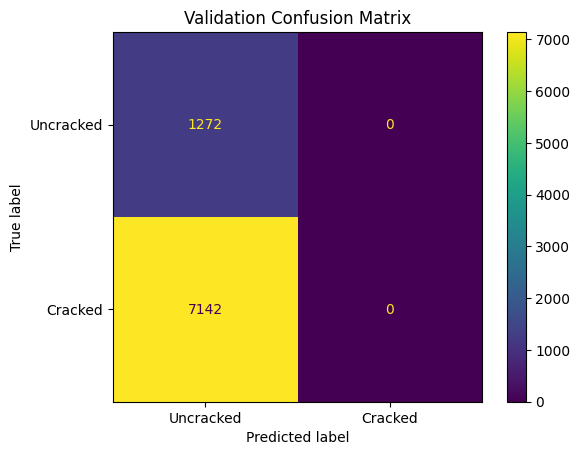

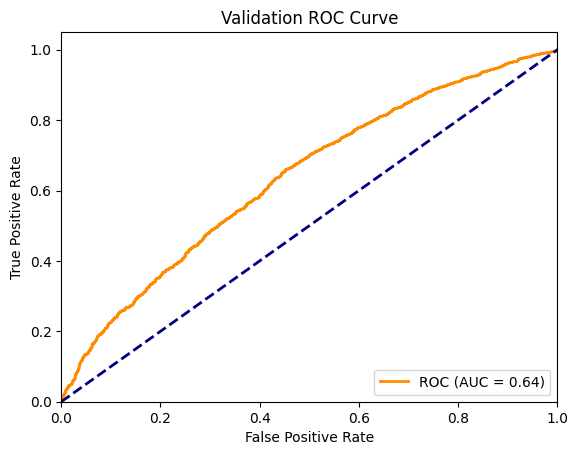

Validation - Loss: 3.4814 | Acc: 0.1512 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.6365
Epoch 0/50 | Train Loss: 1.0361 | Val Loss: 3.4814 | Val F1: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


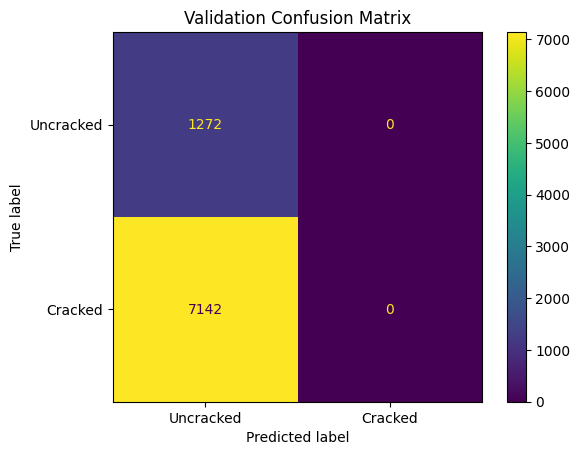

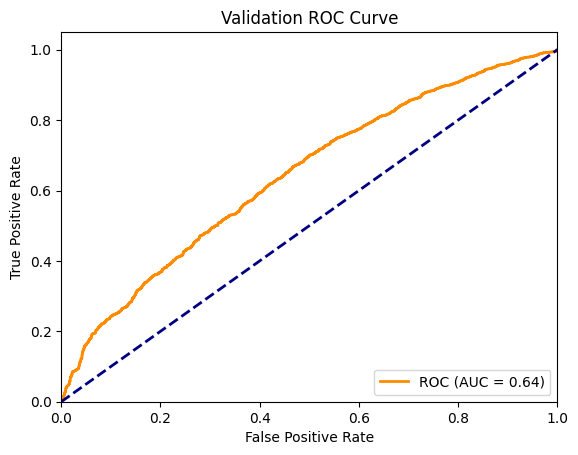

Validation - Loss: 3.8758 | Acc: 0.1512 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.6417
Epoch 1/50 | Train Loss: 1.0230 | Val Loss: 3.8758 | Val F1: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


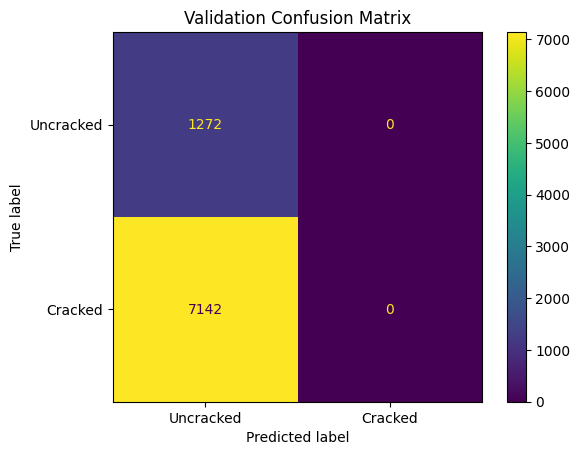

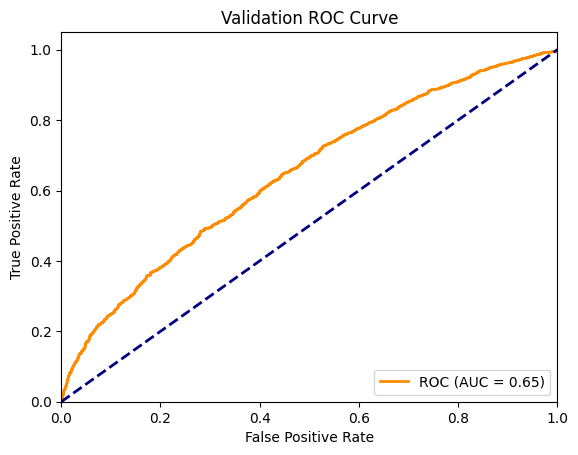

Validation - Loss: 4.8849 | Acc: 0.1512 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.6454
Epoch 2/50 | Train Loss: 1.0171 | Val Loss: 4.8849 | Val F1: 0.0000


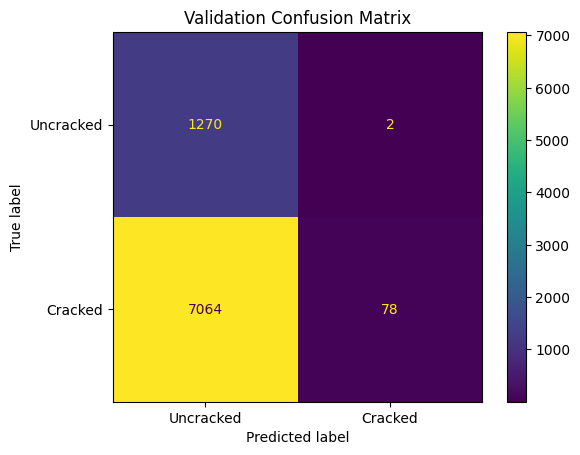

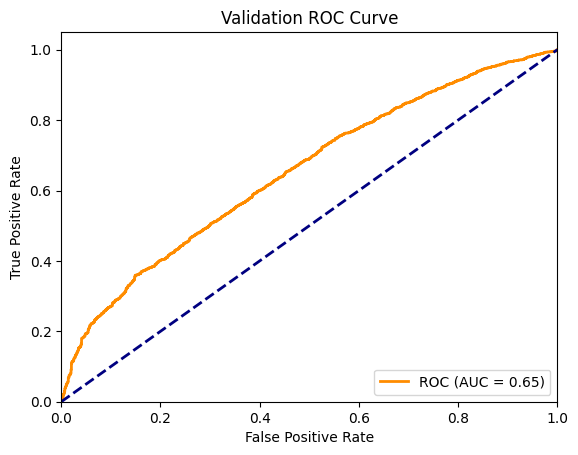

Validation - Loss: 4.6674 | Acc: 0.1602 | Precision: 0.9750 | Recall: 0.0109 | F1: 0.0216 | AUC: 0.6523
Epoch 3/50 | Train Loss: 1.0128 | Val Loss: 4.6674 | Val F1: 0.0216
New best F1: 0.0216, checkpoint saved.


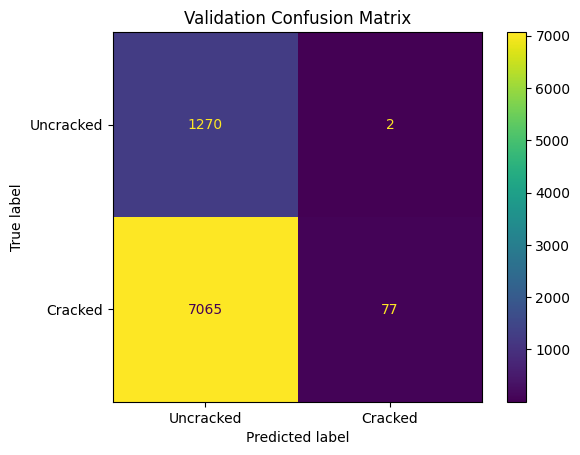

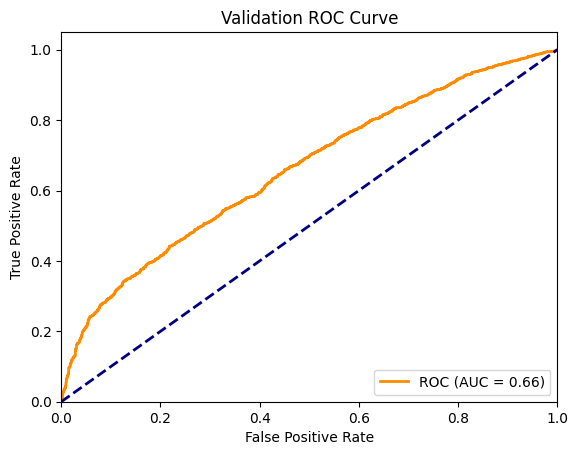

Validation - Loss: 4.3468 | Acc: 0.1601 | Precision: 0.9747 | Recall: 0.0108 | F1: 0.0213 | AUC: 0.6588
Epoch 4/50 | Train Loss: 1.0067 | Val Loss: 4.3468 | Val F1: 0.0213


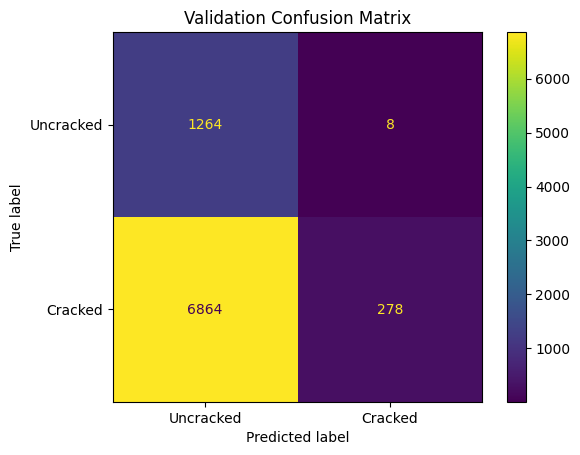

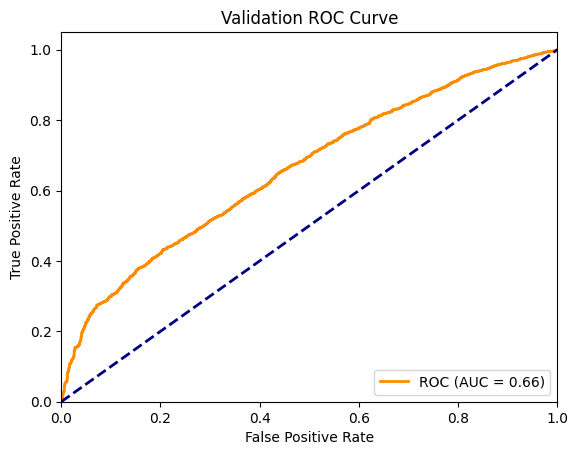

Validation - Loss: 4.7918 | Acc: 0.1833 | Precision: 0.9720 | Recall: 0.0389 | F1: 0.0749 | AUC: 0.6599
Epoch 5/50 | Train Loss: 1.0024 | Val Loss: 4.7918 | Val F1: 0.0749
New best F1: 0.0749, checkpoint saved.


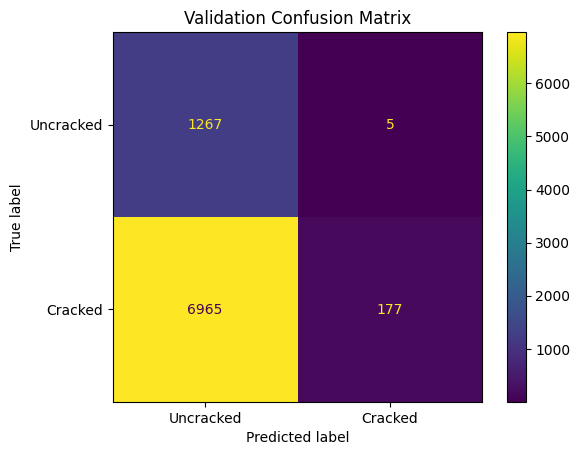

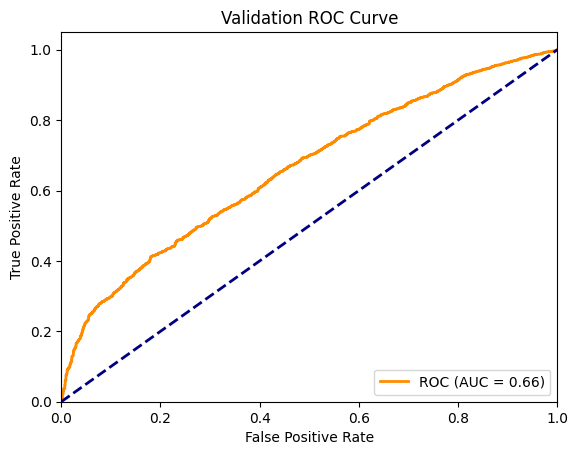

Validation - Loss: 5.5267 | Acc: 0.1716 | Precision: 0.9725 | Recall: 0.0248 | F1: 0.0483 | AUC: 0.6609
Epoch 6/50 | Train Loss: 0.9980 | Val Loss: 5.5267 | Val F1: 0.0483


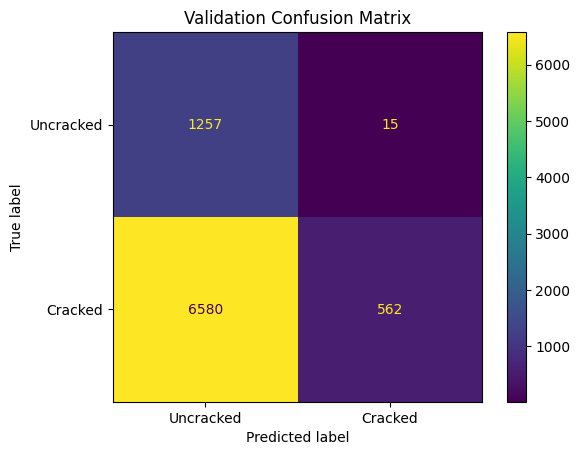

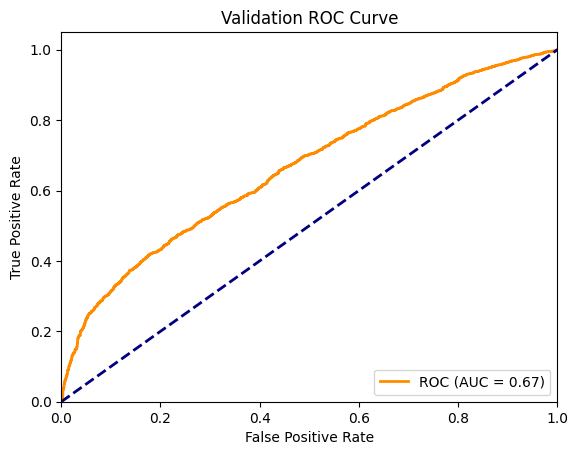

Validation - Loss: 4.9713 | Acc: 0.2162 | Precision: 0.9740 | Recall: 0.0787 | F1: 0.1456 | AUC: 0.6653
Epoch 7/50 | Train Loss: 0.9945 | Val Loss: 4.9713 | Val F1: 0.1456
New best F1: 0.1456, checkpoint saved.


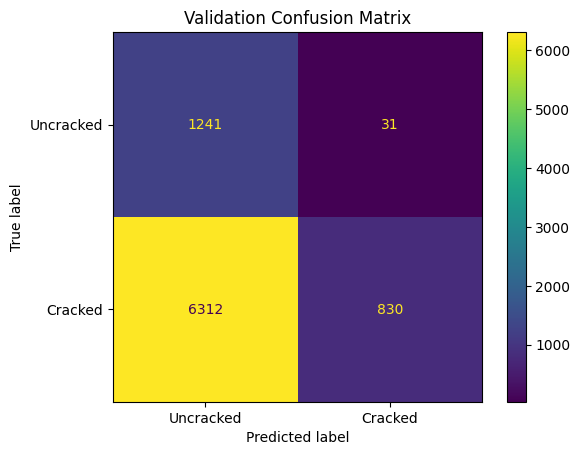

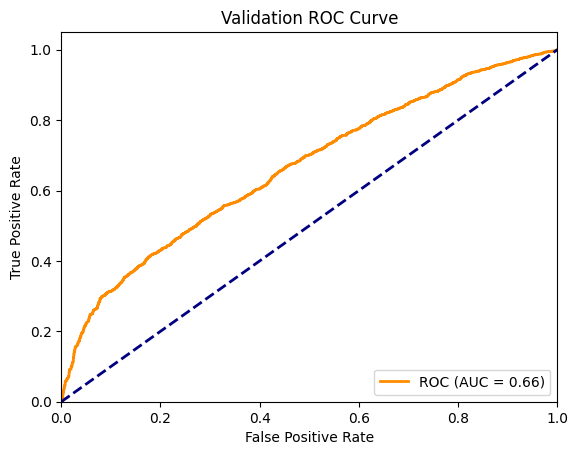

Validation - Loss: 4.9298 | Acc: 0.2461 | Precision: 0.9640 | Recall: 0.1162 | F1: 0.2074 | AUC: 0.6638
Epoch 8/50 | Train Loss: 0.9929 | Val Loss: 4.9298 | Val F1: 0.2074
New best F1: 0.2074, checkpoint saved.


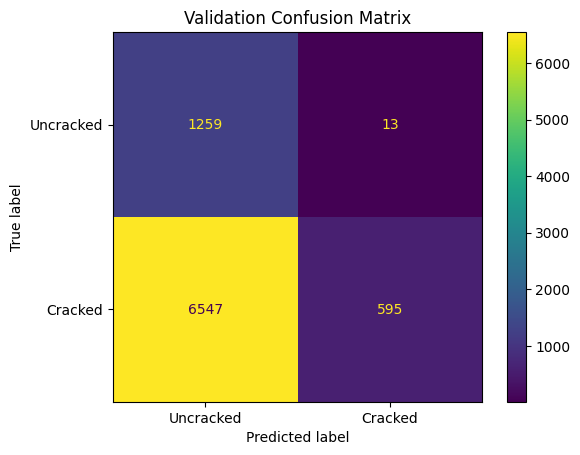

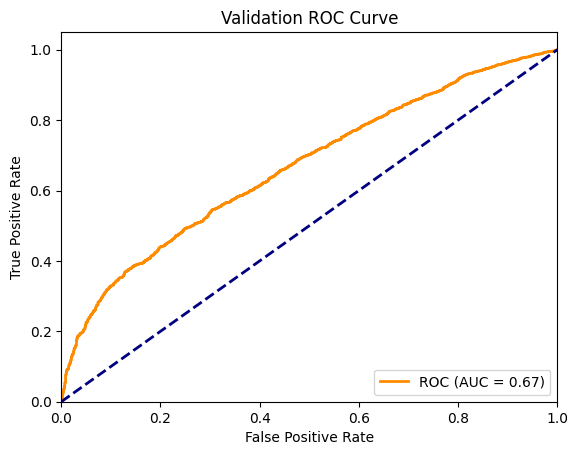

Validation - Loss: 5.0838 | Acc: 0.2203 | Precision: 0.9786 | Recall: 0.0833 | F1: 0.1535 | AUC: 0.6669
Epoch 9/50 | Train Loss: 0.9920 | Val Loss: 5.0838 | Val F1: 0.1535


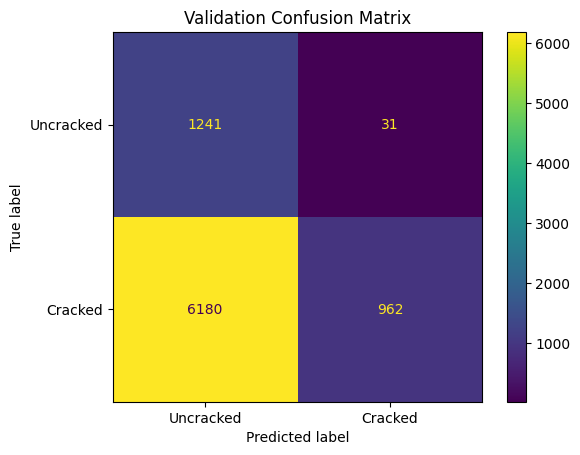

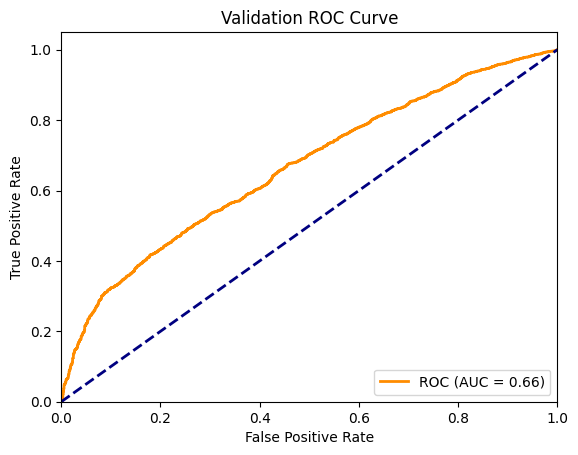

Validation - Loss: 5.2989 | Acc: 0.2618 | Precision: 0.9688 | Recall: 0.1347 | F1: 0.2365 | AUC: 0.6648
Epoch 10/50 | Train Loss: 0.9888 | Val Loss: 5.2989 | Val F1: 0.2365
New best F1: 0.2365, checkpoint saved.
Early stopping triggered.


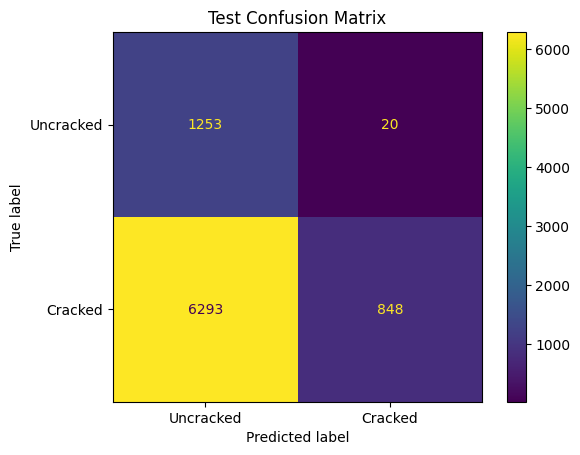

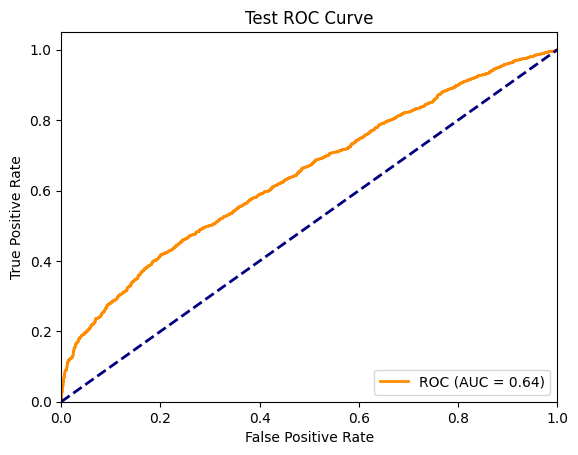

Test - Loss: 4.9578 | Acc: 0.2497 | Precision: 0.9770 | Recall: 0.1188 | F1: 0.2118 | AUC: 0.6434
Test - Loss: 4.9578 | Acc: 0.2497 | Precision: 0.9770 | Recall: 0.1188 | F1: 0.2118 | AUC: 0.6434

Final Test Accuracy: 24.97%
Final Test Metrics: {'loss': 4.957830429077148, 'accuracy': np.float64(0.24970287615878298), 'precision': 0.9769585253456221, 'recall': 0.11875087522755917, 'f1': 0.21176176801098764, 'auc': np.float64(0.6433790774603754)}


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuration
sdnet_path = '/content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL'
output_path = '/content/drive/MyDrive/Deep Learning/final/split_data'
CONFIG = {
    'lr': 1e-5,
    'dropout_p': 0.5,
    'batch_size': 32,
    'epochs': 50,
    'image_size': 64
}
os.makedirs(output_path, exist_ok=True)
print(f"Using dataset path: {sdnet_path}\nOutput path: {output_path}")

# Transforms
TRANSFORM = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class CustomImageDataset:
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.class_to_idx = {'Cracked': 0, 'Uncracked': 1}
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[label]
        return img, torch.tensor(label, dtype=torch.long)

# Load splits from CSV
def load_split(name, output_path):
    csv_path = os.path.join(output_path, f'{name}_split.csv')
    df = pd.read_csv(csv_path)
    return df['file_path'].tolist(), df['label'].tolist()

train_files, train_labels = load_split('train', output_path)
val_files, val_labels = load_split('validation', output_path)
test_files, test_labels = load_split('test', output_path)

# Print split distribution
def print_split_distribution(split_files, split_labels, name=""):
    counts = Counter(split_labels)
    print(f"{name} Distribution:", counts)

print("\nSplit Distributions:")
print_split_distribution(train_files, train_labels, "Training")
print_split_distribution(val_files, val_labels, "Validation")
print_split_distribution(test_files, test_labels, "Test")

# Create datasets and data loaders
train_dataset = CustomImageDataset(train_files, train_labels, transform=TRANSFORM)
val_dataset = CustomImageDataset(val_files, val_labels, transform=TRANSFORM)
test_dataset = CustomImageDataset(test_files, test_labels, transform=TRANSFORM)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Model
class SimpleCNN(nn.Module):
    def __init__(self, dropout_p=CONFIG['dropout_p']):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (CONFIG['image_size'] // 4) * (CONFIG['image_size'] // 4), 24), nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(24, 1),
            nn.Sigmoid()  # Sigmoid for probability output
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# Focal Loss (Adjusted for float targets)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        # Convert integer targets to float (0.0 or 1.0)
        targets = targets.float()
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

# Evaluation with ROC
def evaluate_model(model, loader, device, loader_name="Validation"):
    model.eval()
    criterion = nn.BCELoss()  # Changed to BCELoss to match Sigmoid output
    all_labels, all_preds, all_scores = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)  # Cast to float
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            scores = outputs.cpu().numpy()  # Already probabilities due to Sigmoid
            preds = (scores > 0.5).astype(int)
            all_labels.extend(labels.cpu().numpy().flatten())
            all_preds.extend(preds.flatten())
            all_scores.extend(scores.flatten())
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, pos_label=1)
    recall = recall_score(all_labels, all_preds, pos_label=1)
    f1 = f1_score(all_labels, all_preds, pos_label=1)
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Uncracked', 'Cracked'])
    disp.plot()
    plt.title(f"{loader_name} Confusion Matrix")
    plt.show()
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{loader_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    print(f"{loader_name} - Loss: {loss.item():.4f} | Acc: {accuracy:.4f} | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")
    return {'loss': loss.item(), 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': roc_auc}

# Training
def train_model(model, train_loader, val_loader, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = FocalLoss(alpha=6.0)
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    checkpoint_path = os.path.join(output_path, 'checkpoint.pth')
    start_epoch = 0
    best_f1 = 0
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_f1 = checkpoint['best_f1']
        print(f"Resuming from checkpoint at epoch {start_epoch} with best F1: {best_f1:.4f}")
        for param_group in optimizer.param_groups:
            param_group['lr'] = CONFIG['lr']
        print(f"Updated learning rate to {CONFIG['lr']}")

    for epoch in range(start_epoch, CONFIG['epochs'] + 1):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)  # Cast to float
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, device, "Validation")
        val_loss = val_metrics['loss']
        scheduler.step(val_loss)
        print(f"Epoch {epoch}/{CONFIG['epochs']} | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val F1: {val_metrics['f1']:.4f}")
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            torch.save(model.state_dict(), os.path.join(output_path, 'best_model.pth'))
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_f1': best_f1
            }, checkpoint_path)
            print(f"New best F1: {best_f1:.4f}, checkpoint saved.")
        if epoch - start_epoch >= 10 and all(val_metrics['f1'] <= best_f1 for _ in range(10)):
            print("Early stopping triggered.")
            break
    test_metrics = evaluate_model(model, test_loader, device, "Test")
    print(f"Test - Loss: {test_metrics['loss']:.4f} | Acc: {test_metrics['accuracy']:.4f} | "
          f"Precision: {test_metrics['precision']:.4f} | Recall: {test_metrics['recall']:.4f} | "
          f"F1: {test_metrics['f1']:.4f} | AUC: {test_metrics['auc']:.4f}")
    return test_metrics['accuracy'], test_metrics

# Main execution
try:
    print("\nTraining with fixed splits...")
    model = SimpleCNN()
    accuracy, metrics = train_model(model, train_loader, val_loader, test_loader)
    print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")
    print(f"Final Test Metrics: {metrics}")
except Exception as e:
    print(f"Script execution failed: {str(e)}")

Using dataset path: /content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL
Output path: /content/drive/MyDrive/Deep Learning/final/split_data

Split Distributions:
Training Distribution: Counter({'Uncracked': 16662, 'Cracked': 16662})
Validation Distribution: Counter({'Uncracked': 7142, 'Cracked': 1272})
Test Distribution: Counter({'Uncracked': 7141, 'Cracked': 1273})

Training with fixed splits...
Loading checkpoint...
Resuming from checkpoint at epoch 11 with best F1: 0.2365
Updated learning rate to 0.0001


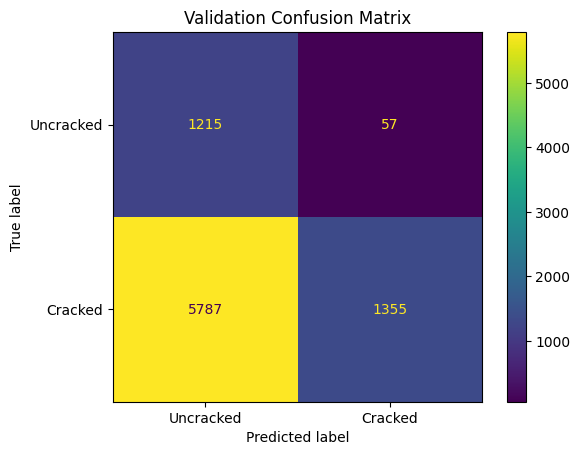

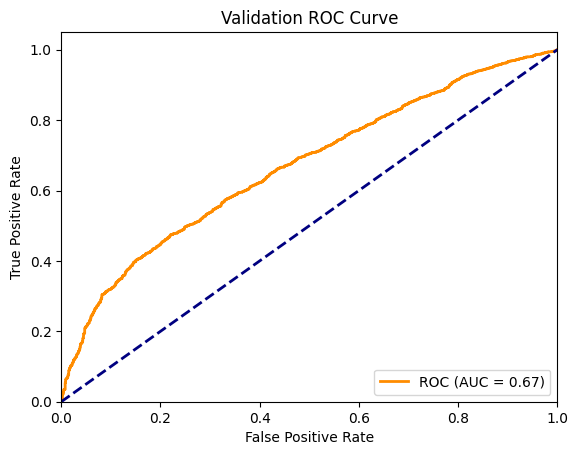

Validation - Loss: 7.8673 | Acc: 0.3054 | Precision: 0.9596 | Recall: 0.1897 | F1: 0.3168 | AUC: 0.6678
Epoch 11/50 | Train Loss: 0.9968 | Val Loss: 7.8673 | Val F1: 0.3168
New best F1: 0.3168, checkpoint saved.


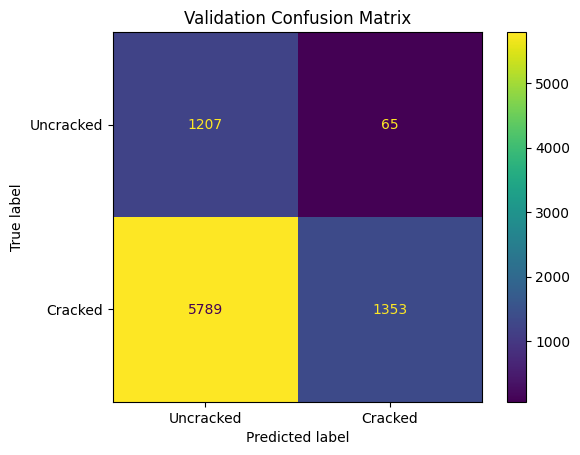

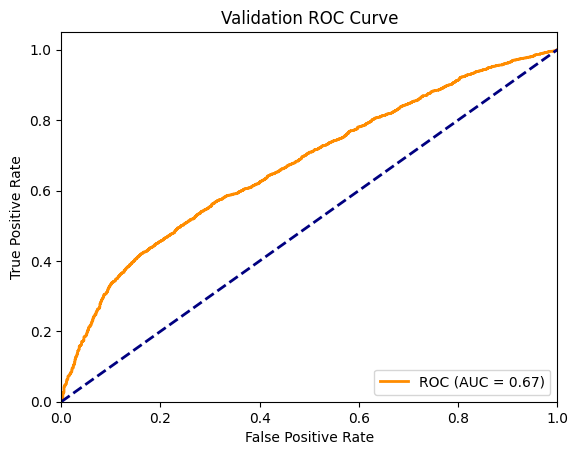

Validation - Loss: 8.9593 | Acc: 0.3043 | Precision: 0.9542 | Recall: 0.1894 | F1: 0.3161 | AUC: 0.6707
Epoch 12/50 | Train Loss: 0.9810 | Val Loss: 8.9593 | Val F1: 0.3161


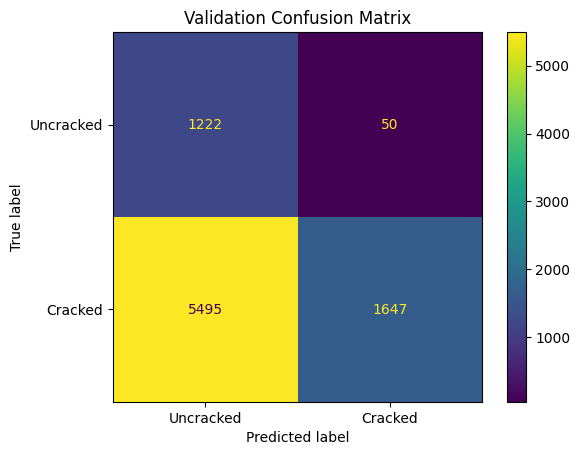

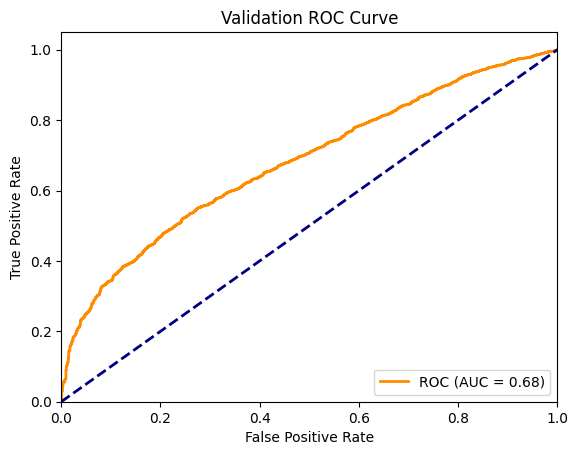

Validation - Loss: 7.9978 | Acc: 0.3410 | Precision: 0.9705 | Recall: 0.2306 | F1: 0.3727 | AUC: 0.6802
Epoch 13/50 | Train Loss: 0.9666 | Val Loss: 7.9978 | Val F1: 0.3727
New best F1: 0.3727, checkpoint saved.


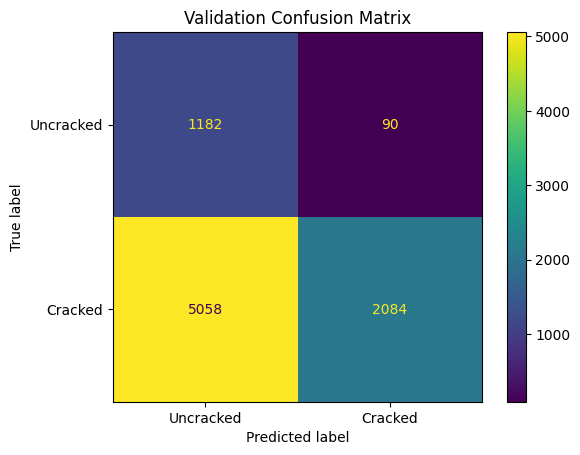

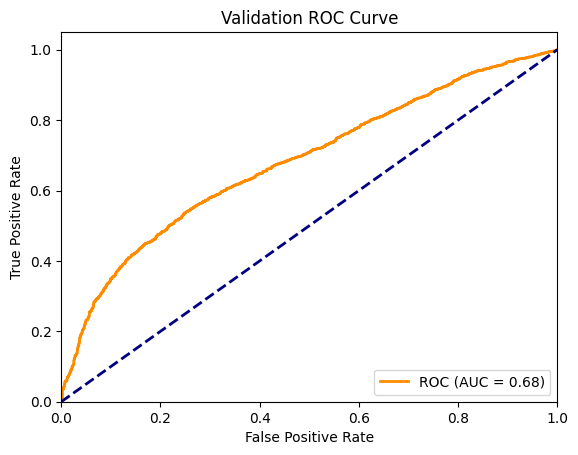

Validation - Loss: 7.2459 | Acc: 0.3882 | Precision: 0.9586 | Recall: 0.2918 | F1: 0.4474 | AUC: 0.6815
Epoch 14/50 | Train Loss: 0.9554 | Val Loss: 7.2459 | Val F1: 0.4474
New best F1: 0.4474, checkpoint saved.


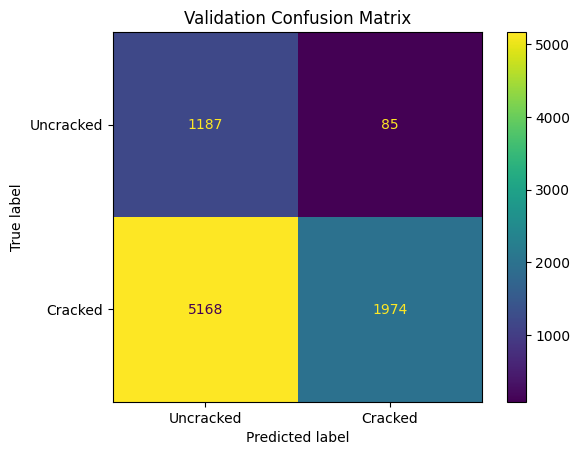

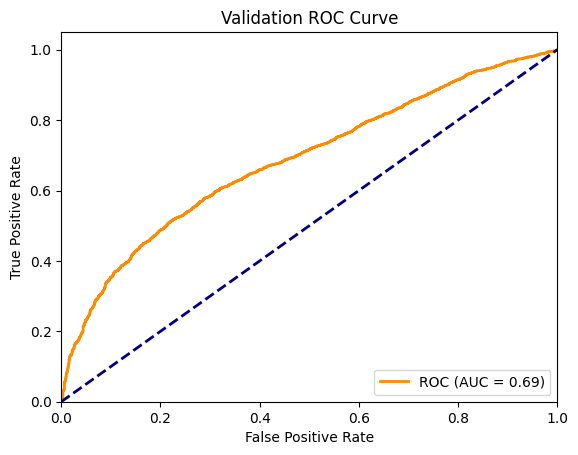

Validation - Loss: 7.3211 | Acc: 0.3757 | Precision: 0.9587 | Recall: 0.2764 | F1: 0.4291 | AUC: 0.6854
Epoch 15/50 | Train Loss: 0.9449 | Val Loss: 7.3211 | Val F1: 0.4291


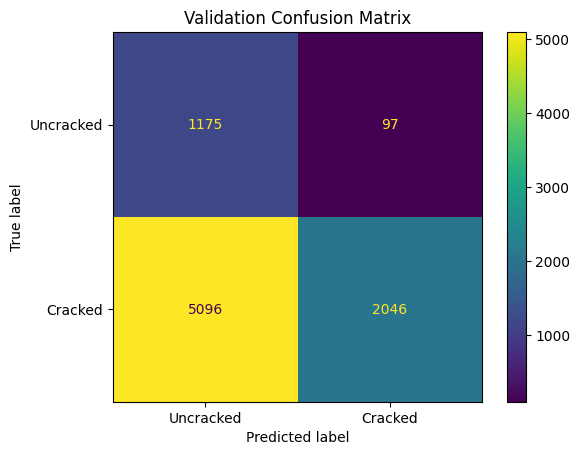

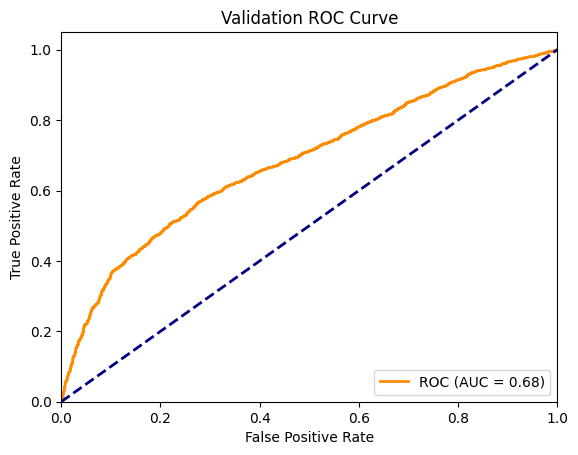

Validation - Loss: 7.1673 | Acc: 0.3828 | Precision: 0.9547 | Recall: 0.2865 | F1: 0.4407 | AUC: 0.6824
Epoch 16/50 | Train Loss: 0.9364 | Val Loss: 7.1673 | Val F1: 0.4407


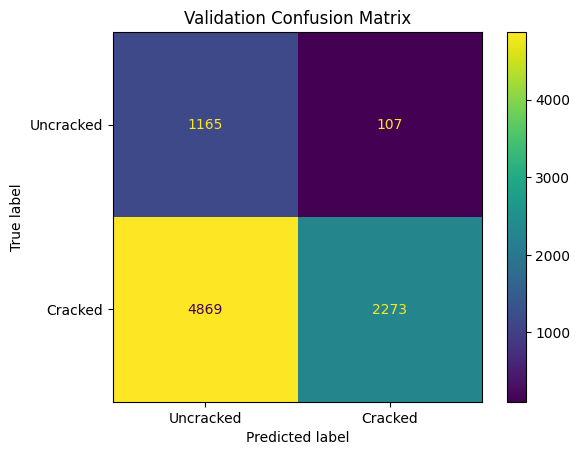

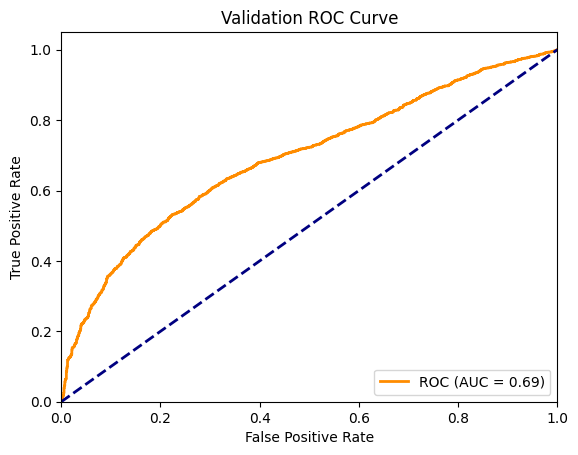

Validation - Loss: 6.1060 | Acc: 0.4086 | Precision: 0.9550 | Recall: 0.3183 | F1: 0.4774 | AUC: 0.6924
Epoch 17/50 | Train Loss: 0.9261 | Val Loss: 6.1060 | Val F1: 0.4774
New best F1: 0.4774, checkpoint saved.


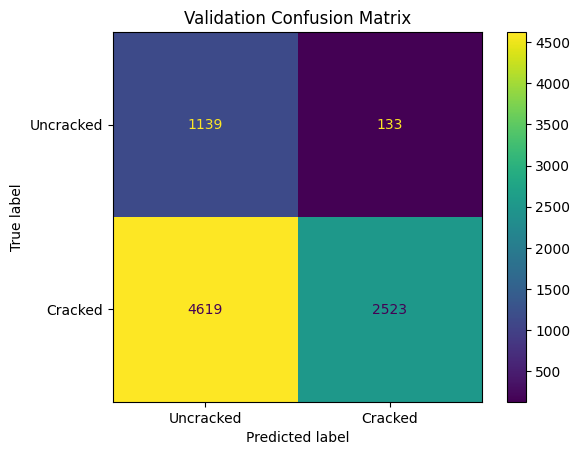

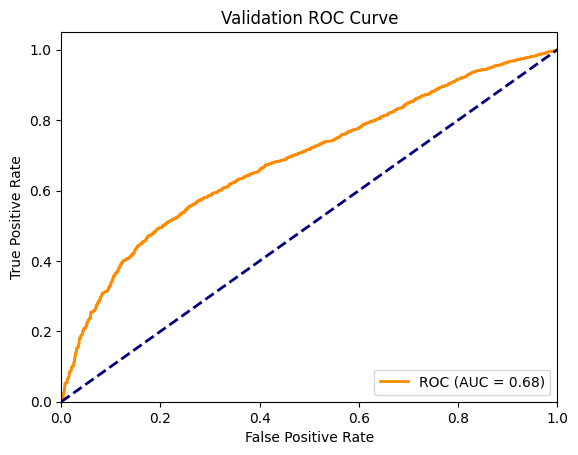

Validation - Loss: 7.2760 | Acc: 0.4352 | Precision: 0.9499 | Recall: 0.3533 | F1: 0.5150 | AUC: 0.6848
Epoch 18/50 | Train Loss: 0.9185 | Val Loss: 7.2760 | Val F1: 0.5150
New best F1: 0.5150, checkpoint saved.


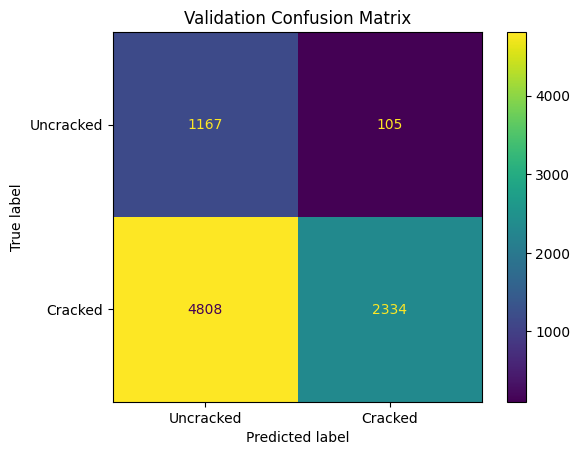

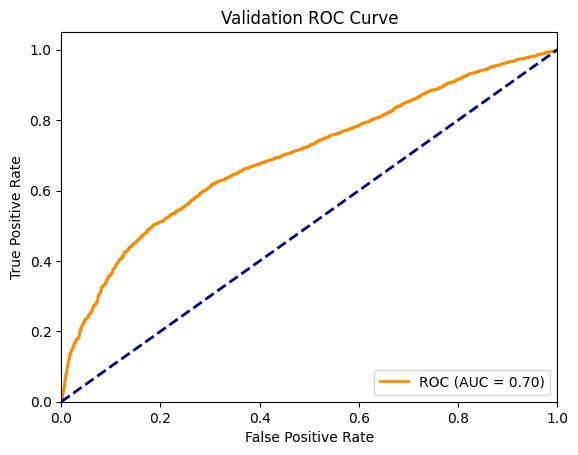

Validation - Loss: 6.3094 | Acc: 0.4161 | Precision: 0.9569 | Recall: 0.3268 | F1: 0.4872 | AUC: 0.6959
Epoch 19/50 | Train Loss: 0.9065 | Val Loss: 6.3094 | Val F1: 0.4872


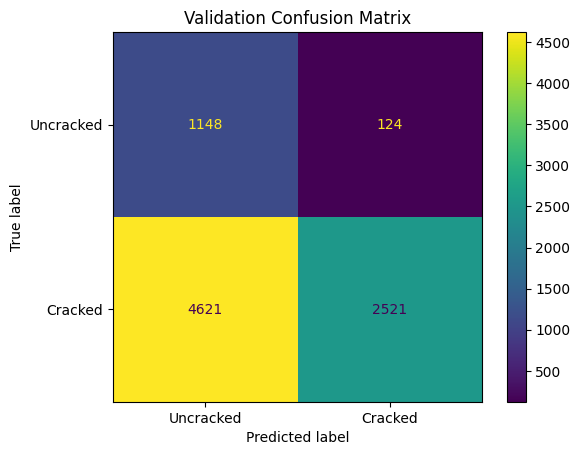

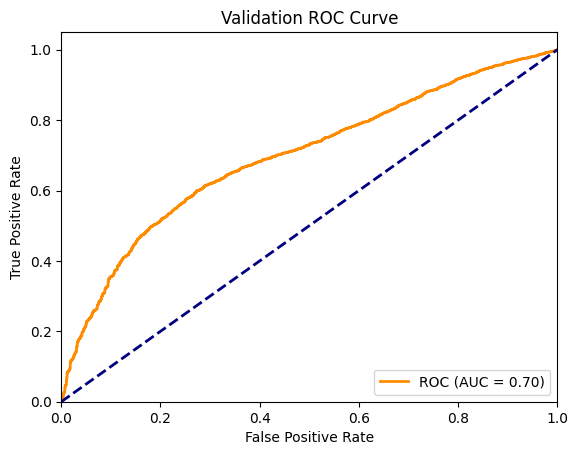

Validation - Loss: 5.8914 | Acc: 0.4361 | Precision: 0.9531 | Recall: 0.3530 | F1: 0.5152 | AUC: 0.6962
Epoch 20/50 | Train Loss: 0.9002 | Val Loss: 5.8914 | Val F1: 0.5152
New best F1: 0.5152, checkpoint saved.


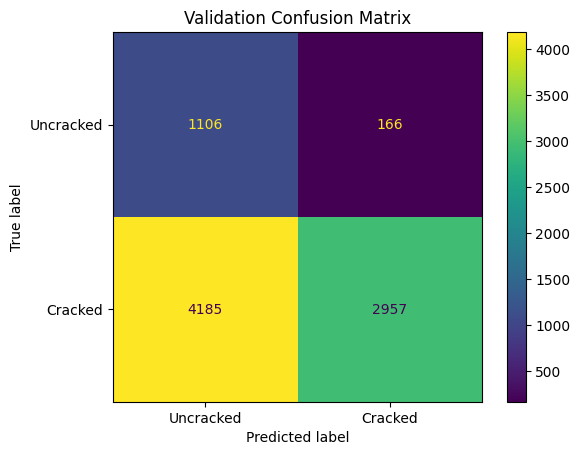

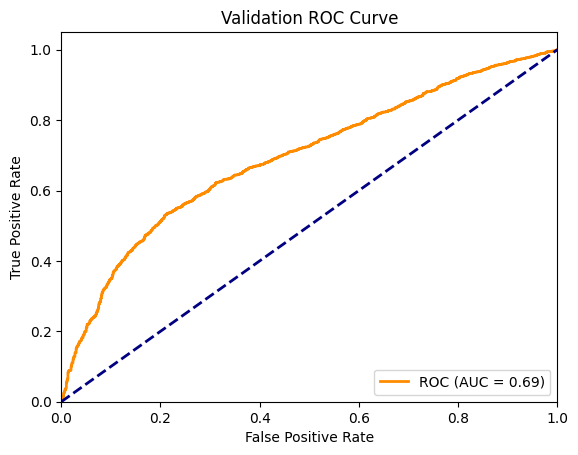

Validation - Loss: 5.7032 | Acc: 0.4829 | Precision: 0.9468 | Recall: 0.4140 | F1: 0.5761 | AUC: 0.6931
Epoch 21/50 | Train Loss: 0.8959 | Val Loss: 5.7032 | Val F1: 0.5761
New best F1: 0.5761, checkpoint saved.
Early stopping triggered.


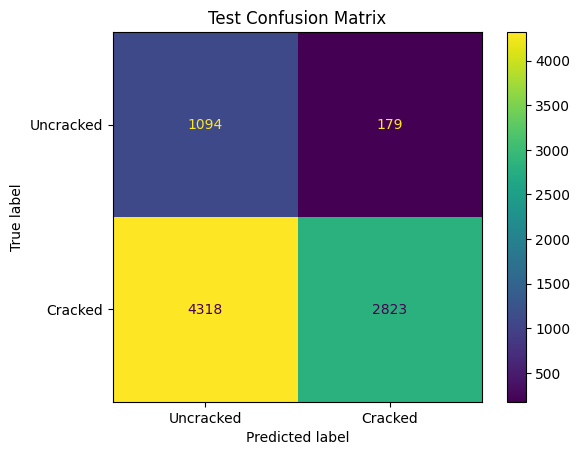

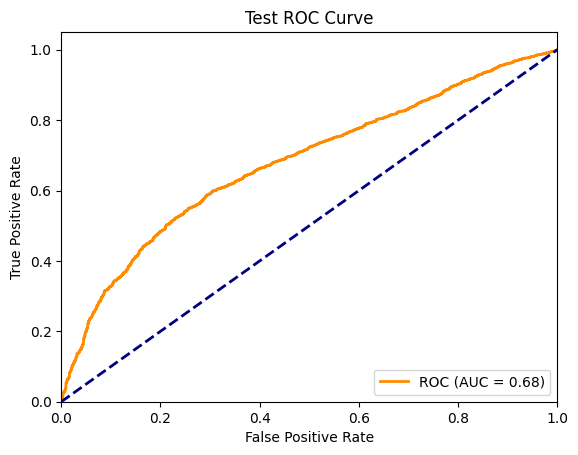

Test - Loss: 4.6551 | Acc: 0.4655 | Precision: 0.9404 | Recall: 0.3953 | F1: 0.5566 | AUC: 0.6788
Test - Loss: 4.6551 | Acc: 0.4655 | Precision: 0.9404 | Recall: 0.3953 | F1: 0.5566 | AUC: 0.6788

Final Test Accuracy: 46.55%
Final Test Metrics: {'loss': 4.655124187469482, 'accuracy': np.float64(0.4655336344188258), 'precision': 0.9403730846102598, 'recall': 0.3953227839238202, 'f1': 0.5566400473232771, 'auc': np.float64(0.6788018537608467)}


In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuration
sdnet_path = '/content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL'
output_path = '/content/drive/MyDrive/Deep Learning/final/split_data'
CONFIG = {
    'lr': 1e-4,
    'dropout_p': 0.5,
    'batch_size': 32,
    'epochs': 50,
    'image_size': 64
}
os.makedirs(output_path, exist_ok=True)
print(f"Using dataset path: {sdnet_path}\nOutput path: {output_path}")

# Transforms
TRANSFORM = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class CustomImageDataset:
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.class_to_idx = {'Cracked': 0, 'Uncracked': 1}
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[label]
        return img, torch.tensor(label, dtype=torch.long)

# Load splits from CSV
def load_split(name, output_path):
    csv_path = os.path.join(output_path, f'{name}_split.csv')
    df = pd.read_csv(csv_path)
    return df['file_path'].tolist(), df['label'].tolist()

train_files, train_labels = load_split('train', output_path)
val_files, val_labels = load_split('validation', output_path)
test_files, test_labels = load_split('test', output_path)

# Print split distribution
def print_split_distribution(split_files, split_labels, name=""):
    counts = Counter(split_labels)
    print(f"{name} Distribution:", counts)

print("\nSplit Distributions:")
print_split_distribution(train_files, train_labels, "Training")
print_split_distribution(val_files, val_labels, "Validation")
print_split_distribution(test_files, test_labels, "Test")

# Create datasets and data loaders
train_dataset = CustomImageDataset(train_files, train_labels, transform=TRANSFORM)
val_dataset = CustomImageDataset(val_files, val_labels, transform=TRANSFORM)
test_dataset = CustomImageDataset(test_files, test_labels, transform=TRANSFORM)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Model
class SimpleCNN(nn.Module):
    def __init__(self, dropout_p=CONFIG['dropout_p']):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (CONFIG['image_size'] // 4) * (CONFIG['image_size'] // 4), 24), nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(24, 1),
            nn.Sigmoid()  # Sigmoid for probability output
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# Focal Loss (Adjusted for float targets)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        # Convert integer targets to float (0.0 or 1.0)
        targets = targets.float()
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

# Evaluation with ROC
def evaluate_model(model, loader, device, loader_name="Validation"):
    model.eval()
    criterion = nn.BCELoss()  # Changed to BCELoss to match Sigmoid output
    all_labels, all_preds, all_scores = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)  # Cast to float
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            scores = outputs.cpu().numpy()  # Already probabilities due to Sigmoid
            preds = (scores > 0.5).astype(int)
            all_labels.extend(labels.cpu().numpy().flatten())
            all_preds.extend(preds.flatten())
            all_scores.extend(scores.flatten())
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, pos_label=1)
    recall = recall_score(all_labels, all_preds, pos_label=1)
    f1 = f1_score(all_labels, all_preds, pos_label=1)
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Uncracked', 'Cracked'])
    disp.plot()
    plt.title(f"{loader_name} Confusion Matrix")
    plt.show()
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{loader_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    print(f"{loader_name} - Loss: {loss.item():.4f} | Acc: {accuracy:.4f} | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")
    return {'loss': loss.item(), 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': roc_auc}

# Training
def train_model(model, train_loader, val_loader, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = FocalLoss(alpha=6.0)
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    checkpoint_path = os.path.join(output_path, 'checkpoint.pth')
    start_epoch = 0
    best_f1 = 0
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_f1 = checkpoint['best_f1']
        print(f"Resuming from checkpoint at epoch {start_epoch} with best F1: {best_f1:.4f}")
        for param_group in optimizer.param_groups:
            param_group['lr'] = CONFIG['lr']
        print(f"Updated learning rate to {CONFIG['lr']}")

    for epoch in range(start_epoch, CONFIG['epochs'] + 1):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)  # Cast to float
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, device, "Validation")
        val_loss = val_metrics['loss']
        scheduler.step(val_loss)
        print(f"Epoch {epoch}/{CONFIG['epochs']} | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val F1: {val_metrics['f1']:.4f}")
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            torch.save(model.state_dict(), os.path.join(output_path, 'best_model.pth'))
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_f1': best_f1
            }, checkpoint_path)
            print(f"New best F1: {best_f1:.4f}, checkpoint saved.")
        if epoch - start_epoch >= 10 and all(val_metrics['f1'] <= best_f1 for _ in range(10)):
            print("Early stopping triggered.")
            break
    test_metrics = evaluate_model(model, test_loader, device, "Test")
    print(f"Test - Loss: {test_metrics['loss']:.4f} | Acc: {test_metrics['accuracy']:.4f} | "
          f"Precision: {test_metrics['precision']:.4f} | Recall: {test_metrics['recall']:.4f} | "
          f"F1: {test_metrics['f1']:.4f} | AUC: {test_metrics['auc']:.4f}")
    return test_metrics['accuracy'], test_metrics

# Main execution
try:
    print("\nTraining with fixed splits...")
    model = SimpleCNN()
    accuracy, metrics = train_model(model, train_loader, val_loader, test_loader)
    print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")
    print(f"Final Test Metrics: {metrics}")
except Exception as e:
    print(f"Script execution failed: {str(e)}")

Using dataset path: /content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL
Output path: /content/drive/MyDrive/Deep Learning/final/split_data

Split Distributions:
Training Distribution: Counter({'Uncracked': 16662, 'Cracked': 16662})
Validation Distribution: Counter({'Uncracked': 7142, 'Cracked': 1272})
Test Distribution: Counter({'Uncracked': 7141, 'Cracked': 1273})

Training with fixed splits...
Loading checkpoint...
Resuming from checkpoint at epoch 22 with best F1: 0.5761
Updated learning rate to 3e-05


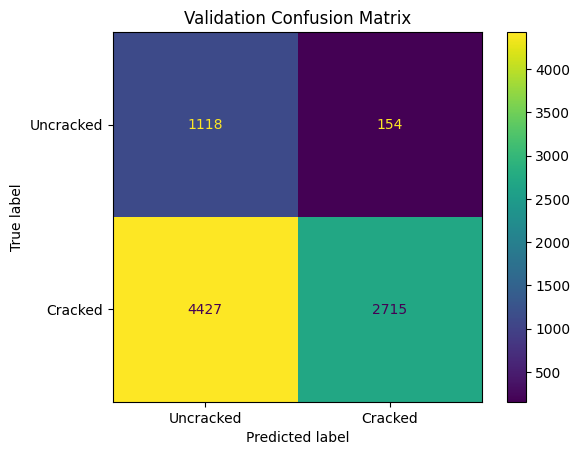

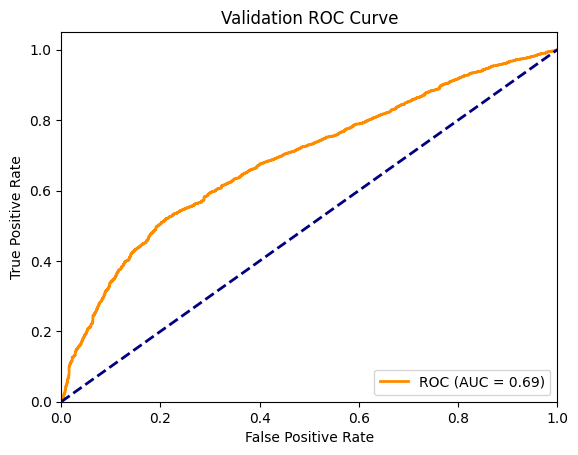

Validation - Loss: 6.3887 | Acc: 0.4556 | Precision: 0.9463 | Recall: 0.3801 | F1: 0.5424 | AUC: 0.6886
Epoch 22/50 | Train Loss: 0.8921 | Val Loss: 6.3887 | Val F1: 0.5424


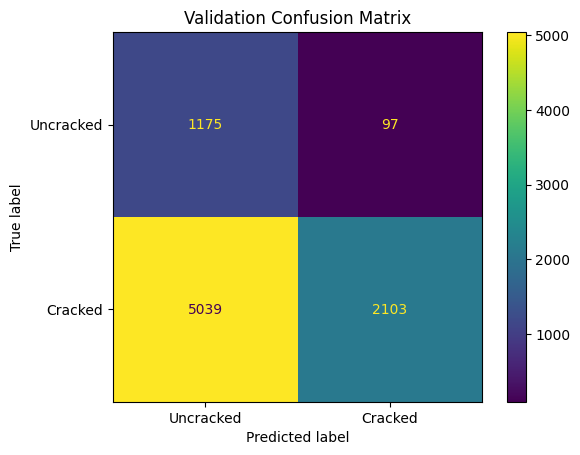

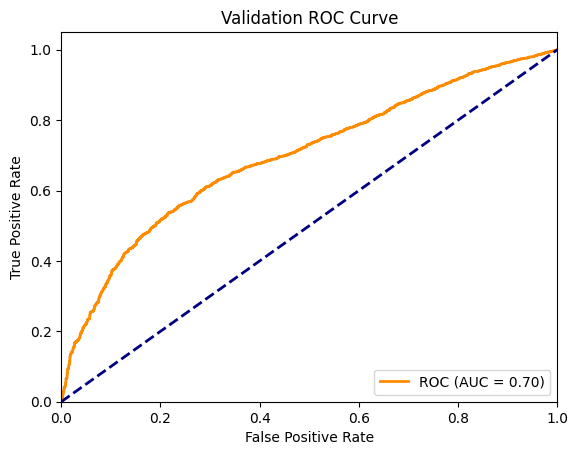

Validation - Loss: 6.7447 | Acc: 0.3896 | Precision: 0.9559 | Recall: 0.2945 | F1: 0.4502 | AUC: 0.6968
Epoch 23/50 | Train Loss: 0.8893 | Val Loss: 6.7447 | Val F1: 0.4502


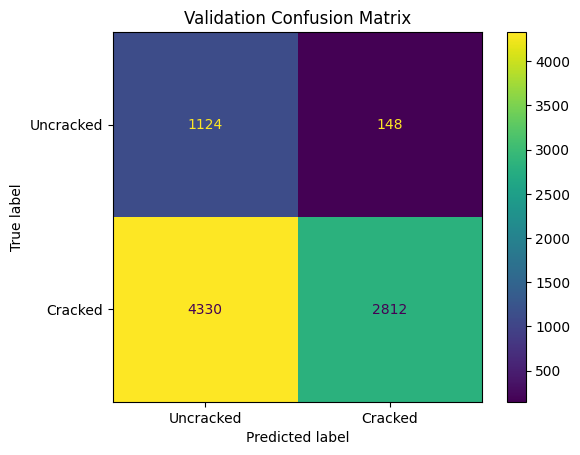

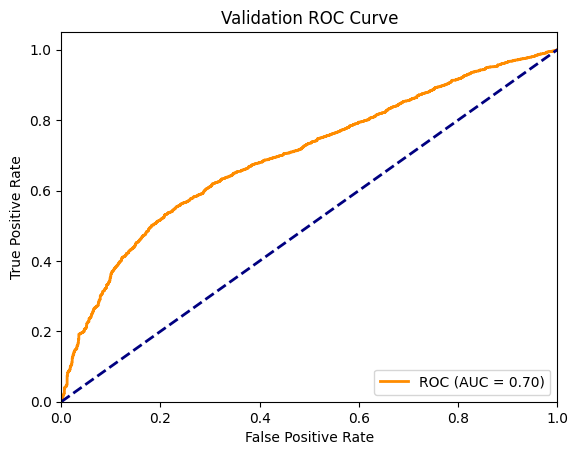

Validation - Loss: 6.0556 | Acc: 0.4678 | Precision: 0.9500 | Recall: 0.3937 | F1: 0.5567 | AUC: 0.6966
Epoch 24/50 | Train Loss: 0.8848 | Val Loss: 6.0556 | Val F1: 0.5567


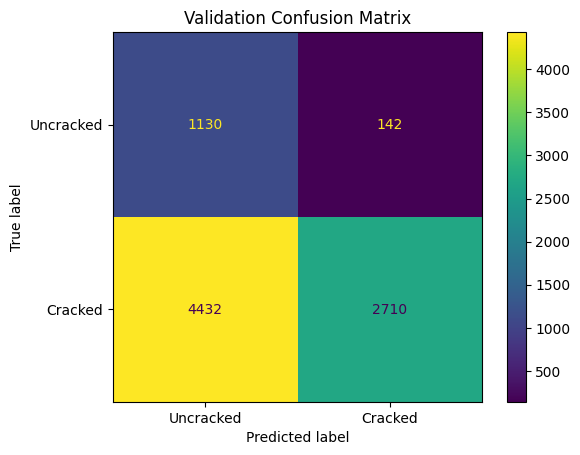

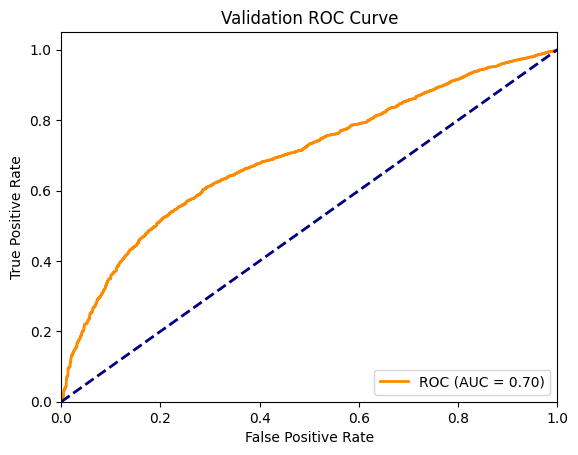

Validation - Loss: 6.3650 | Acc: 0.4564 | Precision: 0.9502 | Recall: 0.3794 | F1: 0.5423 | AUC: 0.6958
Epoch 25/50 | Train Loss: 0.8782 | Val Loss: 6.3650 | Val F1: 0.5423


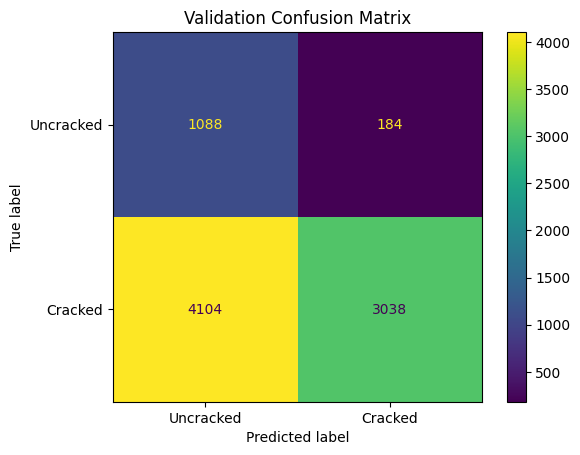

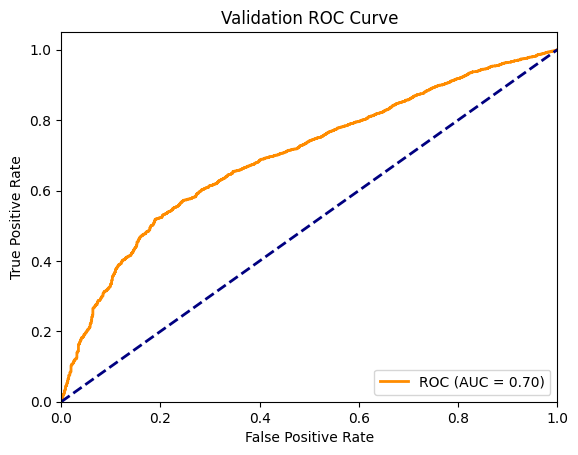

Validation - Loss: 5.2953 | Acc: 0.4904 | Precision: 0.9429 | Recall: 0.4254 | F1: 0.5863 | AUC: 0.6976
Epoch 26/50 | Train Loss: 0.8737 | Val Loss: 5.2953 | Val F1: 0.5863
New best F1: 0.5863, checkpoint saved.


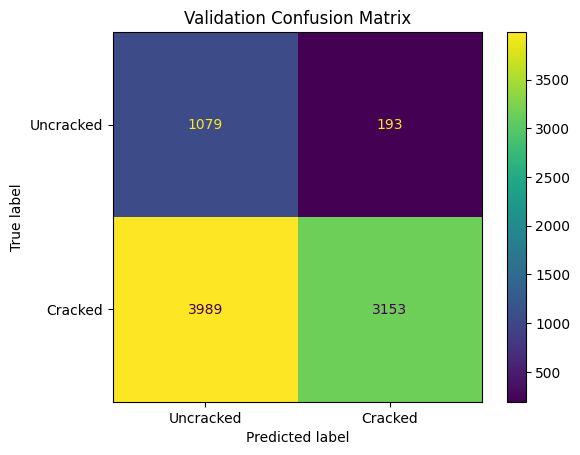

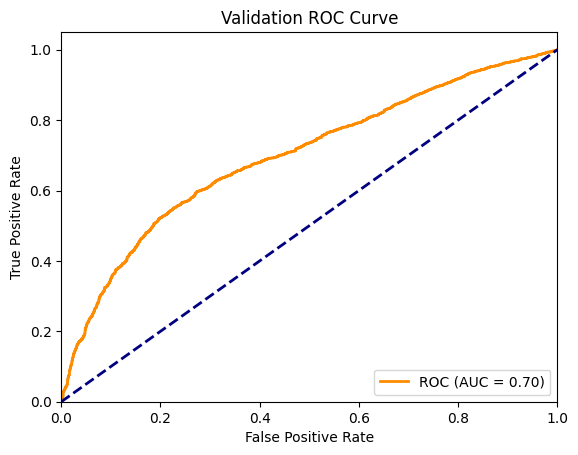

Validation - Loss: 5.2543 | Acc: 0.5030 | Precision: 0.9423 | Recall: 0.4415 | F1: 0.6013 | AUC: 0.6971
Epoch 27/50 | Train Loss: 0.8721 | Val Loss: 5.2543 | Val F1: 0.6013
New best F1: 0.6013, checkpoint saved.


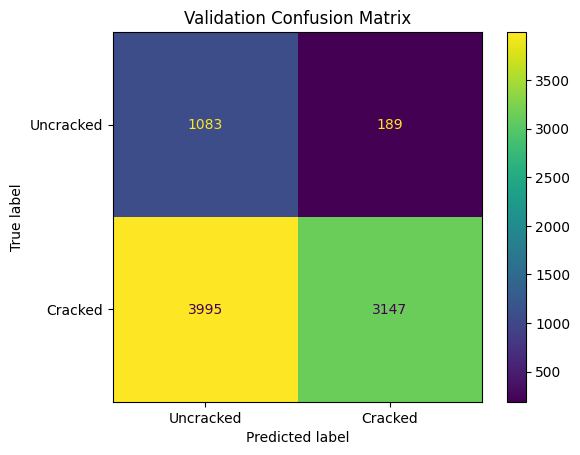

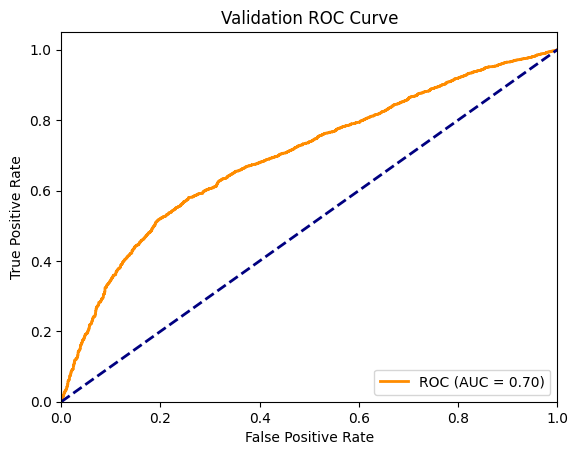

Validation - Loss: 5.2304 | Acc: 0.5027 | Precision: 0.9433 | Recall: 0.4406 | F1: 0.6007 | AUC: 0.6957
Epoch 28/50 | Train Loss: 0.8692 | Val Loss: 5.2304 | Val F1: 0.6007


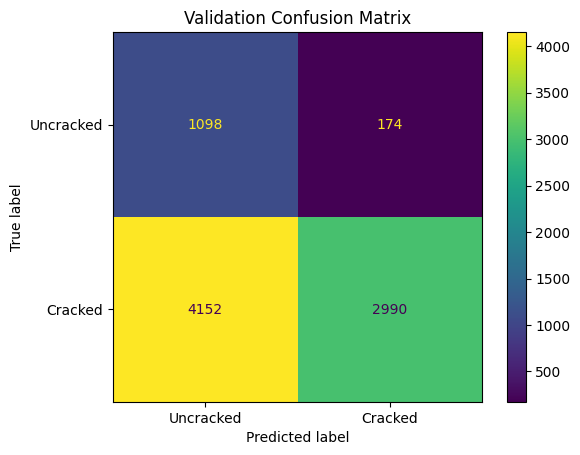

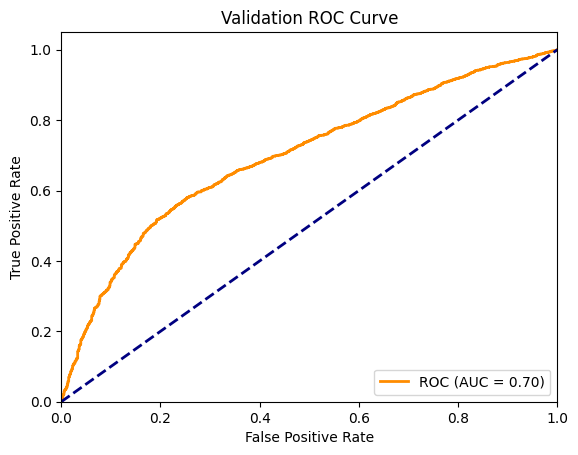

Validation - Loss: 5.2388 | Acc: 0.4859 | Precision: 0.9450 | Recall: 0.4187 | F1: 0.5802 | AUC: 0.6975
Epoch 29/50 | Train Loss: 0.8658 | Val Loss: 5.2388 | Val F1: 0.5802


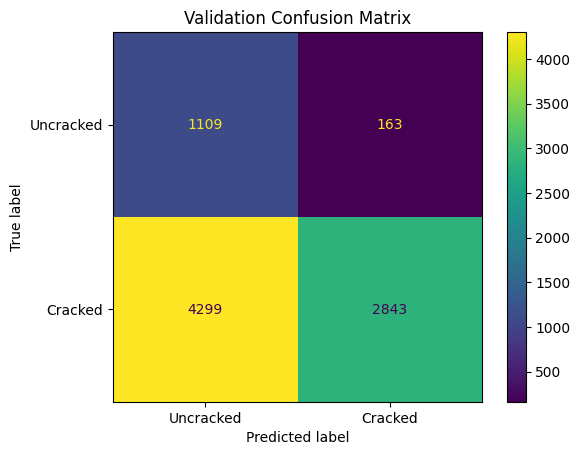

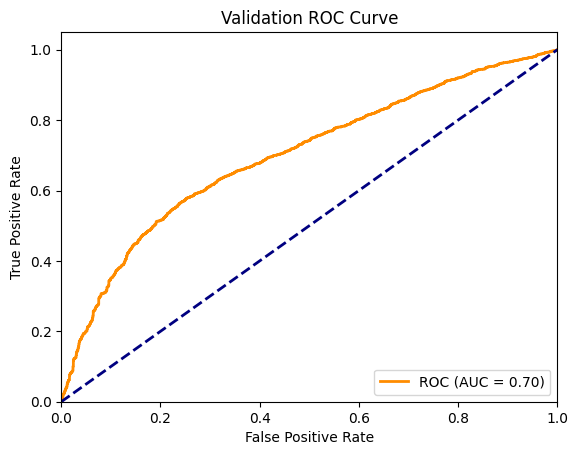

Validation - Loss: 5.3384 | Acc: 0.4697 | Precision: 0.9458 | Recall: 0.3981 | F1: 0.5603 | AUC: 0.6987
Epoch 30/50 | Train Loss: 0.8651 | Val Loss: 5.3384 | Val F1: 0.5603


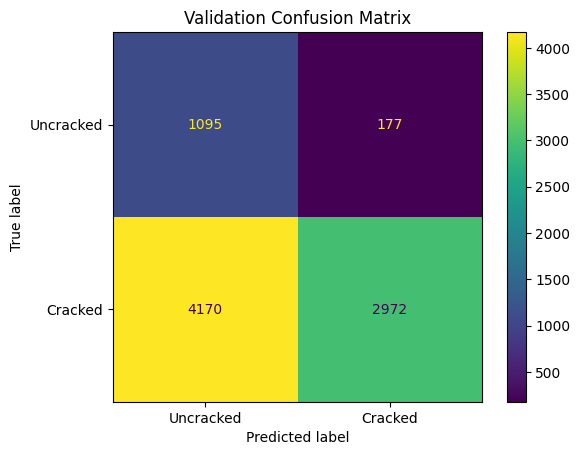

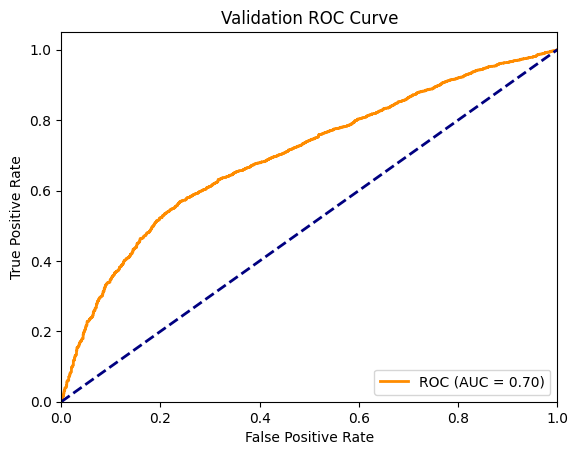

Validation - Loss: 5.1682 | Acc: 0.4834 | Precision: 0.9438 | Recall: 0.4161 | F1: 0.5776 | AUC: 0.6986
Epoch 31/50 | Train Loss: 0.8592 | Val Loss: 5.1682 | Val F1: 0.5776


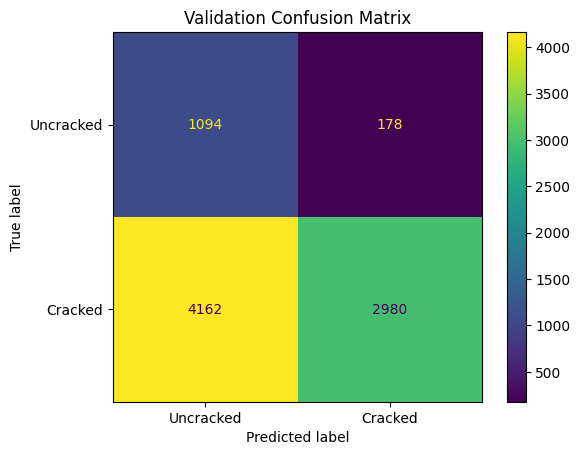

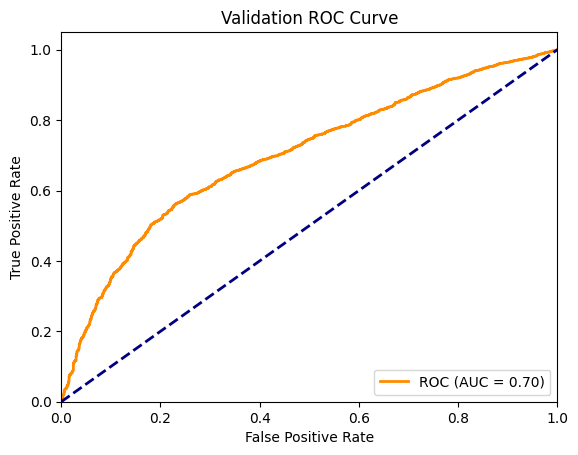

Validation - Loss: 5.1788 | Acc: 0.4842 | Precision: 0.9436 | Recall: 0.4173 | F1: 0.5786 | AUC: 0.6991
Epoch 32/50 | Train Loss: 0.8580 | Val Loss: 5.1788 | Val F1: 0.5786
Early stopping triggered.


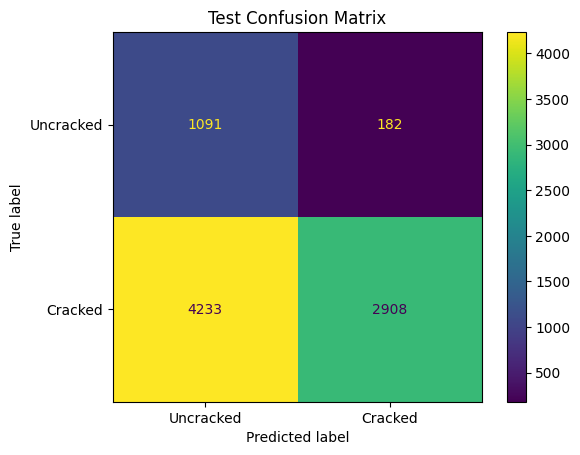

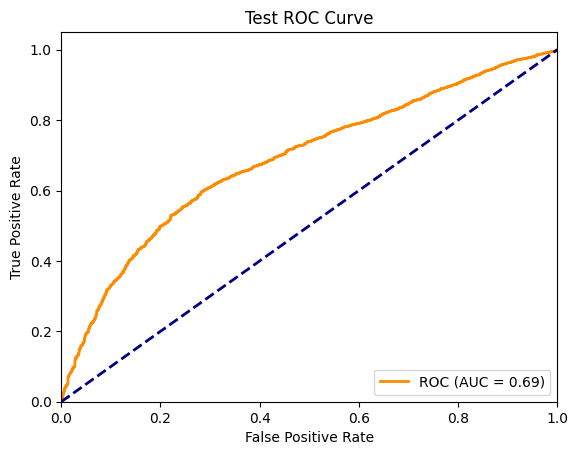

Test - Loss: 3.9903 | Acc: 0.4753 | Precision: 0.9411 | Recall: 0.4072 | F1: 0.5685 | AUC: 0.6878
Test - Loss: 3.9903 | Acc: 0.4753 | Precision: 0.9411 | Recall: 0.4072 | F1: 0.5685 | AUC: 0.6878

Final Test Accuracy: 47.53%
Final Test Metrics: {'loss': 3.990299940109253, 'accuracy': np.float64(0.475279296410744), 'precision': 0.9411003236245955, 'recall': 0.4072258787284694, 'f1': 0.5684683804124719, 'auc': np.float64(0.6877901451549437)}


In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuration
sdnet_path = '/content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL'
output_path = '/content/drive/MyDrive/Deep Learning/final/split_data'
CONFIG = {
    'lr': 3e-5,
    'dropout_p': 0.5,
    'batch_size': 32,
    'epochs': 50,
    'image_size': 64
}
os.makedirs(output_path, exist_ok=True)
print(f"Using dataset path: {sdnet_path}\nOutput path: {output_path}")

# Transforms
TRANSFORM = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class CustomImageDataset:
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.class_to_idx = {'Cracked': 0, 'Uncracked': 1}
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.class_to_idx[label]
        return img, torch.tensor(label, dtype=torch.long)

# Load splits from CSV
def load_split(name, output_path):
    csv_path = os.path.join(output_path, f'{name}_split.csv')
    df = pd.read_csv(csv_path)
    return df['file_path'].tolist(), df['label'].tolist()

train_files, train_labels = load_split('train', output_path)
val_files, val_labels = load_split('validation', output_path)
test_files, test_labels = load_split('test', output_path)

# Print split distribution
def print_split_distribution(split_files, split_labels, name=""):
    counts = Counter(split_labels)
    print(f"{name} Distribution:", counts)

print("\nSplit Distributions:")
print_split_distribution(train_files, train_labels, "Training")
print_split_distribution(val_files, val_labels, "Validation")
print_split_distribution(test_files, test_labels, "Test")

# Create datasets and data loaders
train_dataset = CustomImageDataset(train_files, train_labels, transform=TRANSFORM)
val_dataset = CustomImageDataset(val_files, val_labels, transform=TRANSFORM)
test_dataset = CustomImageDataset(test_files, test_labels, transform=TRANSFORM)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Model
class SimpleCNN(nn.Module):
    def __init__(self, dropout_p=CONFIG['dropout_p']):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (CONFIG['image_size'] // 4) * (CONFIG['image_size'] // 4), 24), nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(24, 1),
            nn.Sigmoid()  # Sigmoid for probability output
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# Focal Loss (Adjusted for float targets)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        # Convert integer targets to float (0.0 or 1.0)
        targets = targets.float()
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

# Evaluation with ROC
def evaluate_model(model, loader, device, loader_name="Validation"):
    model.eval()
    criterion = nn.BCELoss()  # Changed to BCELoss to match Sigmoid output
    all_labels, all_preds, all_scores = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)  # Cast to float
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            scores = outputs.cpu().numpy()  # Already probabilities due to Sigmoid
            preds = (scores > 0.5).astype(int)
            all_labels.extend(labels.cpu().numpy().flatten())
            all_preds.extend(preds.flatten())
            all_scores.extend(scores.flatten())
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, pos_label=1)
    recall = recall_score(all_labels, all_preds, pos_label=1)
    f1 = f1_score(all_labels, all_preds, pos_label=1)
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Uncracked', 'Cracked'])
    disp.plot()
    plt.title(f"{loader_name} Confusion Matrix")
    plt.show()
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{loader_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    print(f"{loader_name} - Loss: {loss.item():.4f} | Acc: {accuracy:.4f} | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {roc_auc:.4f}")
    return {'loss': loss.item(), 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': roc_auc}

# Training
def train_model(model, train_loader, val_loader, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = FocalLoss(alpha=6.0)
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    checkpoint_path = os.path.join(output_path, 'checkpoint.pth')
    start_epoch = 0
    best_f1 = 0
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_f1 = checkpoint['best_f1']
        print(f"Resuming from checkpoint at epoch {start_epoch} with best F1: {best_f1:.4f}")
        for param_group in optimizer.param_groups:
            param_group['lr'] = CONFIG['lr']
        print(f"Updated learning rate to {CONFIG['lr']}")

    for epoch in range(start_epoch, CONFIG['epochs'] + 1):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)  # Cast to float
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, device, "Validation")
        val_loss = val_metrics['loss']
        scheduler.step(val_loss)
        print(f"Epoch {epoch}/{CONFIG['epochs']} | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val F1: {val_metrics['f1']:.4f}")
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            torch.save(model.state_dict(), os.path.join(output_path, 'best_model.pth'))
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_f1': best_f1
            }, checkpoint_path)
            print(f"New best F1: {best_f1:.4f}, checkpoint saved.")
        if epoch - start_epoch >= 10 and all(val_metrics['f1'] <= best_f1 for _ in range(10)):
            print("Early stopping triggered.")
            break
    test_metrics = evaluate_model(model, test_loader, device, "Test")
    print(f"Test - Loss: {test_metrics['loss']:.4f} | Acc: {test_metrics['accuracy']:.4f} | "
          f"Precision: {test_metrics['precision']:.4f} | Recall: {test_metrics['recall']:.4f} | "
          f"F1: {test_metrics['f1']:.4f} | AUC: {test_metrics['auc']:.4f}")
    return test_metrics['accuracy'], test_metrics

# Main execution
try:
    print("\nTraining with fixed splits...")
    model = SimpleCNN()
    accuracy, metrics = train_model(model, train_loader, val_loader, test_loader)
    print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")
    print(f"Final Test Metrics: {metrics}")
except Exception as e:
    print(f"Script execution failed: {str(e)}")

## Step 4 : Transfer Learning with the use of Resnet18(weights='IMAGENET1K_V1') model

In [13]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

# Configuration (match training setup)
CONFIG = {
    'image_size': 224,
    'dropout_p': 0.5,
}

# Define the model (TransferLearningCNN with ResNet18)
class TransferLearningCNN(nn.Module):
    def __init__(self, dropout_p=CONFIG['dropout_p'], freeze_layers=True):
        super().__init__()
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()
        if freeze_layers:
            for param in self.resnet.parameters():
                param.requires_grad = False
            for param in self.resnet.layer3.parameters():
                param.requires_grad = True
            for param in self.resnet.layer4.parameters():
                param.requires_grad = True
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet(x)

# Image preprocessing (match training transforms)
TRANSFORM = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def classify_image(image_path, model, device, threshold=0.3):
    # Load and preprocess the image
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None

    image = TRANSFORM(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        output = model(image)
        score = output.item()
        prediction = 1 if score > threshold else 0
        label = 'Cracked' if prediction == 1 else 'Uncracked'

    return label, score

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model with pre-trained weights
    model = TransferLearningCNN(freeze_layers=True)
    model.to(device)
    print("Using pre-trained ResNet18 weights (IMAGENET1K_V1).")

    # Path to the image
    image_path = "/content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL/D/CD/7057-223.jpg"

    # Classify the image
    threshold = 0.3  # Lowered to improve recall
    label, score = classify_image(image_path, model, device, threshold)
    if label is not None:
        print(f"Image: {image_path}")
        print(f"Prediction: {label}, Confidence: {score:.4f}")

if __name__ == "__main__":
    main()

Using pre-trained ResNet18 weights (IMAGENET1K_V1).
Image: /content/drive/MyDrive/Deep Learning/final/DATA_Maguire_20180517_ALL/D/CD/7057-223.jpg
Prediction: Cracked, Confidence: 0.4788
